## Imports

In [141]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import numpy as np
from scipy.interpolate import UnivariateSpline
import h5py
from scipy.integrate import quadrature
from scipy.stats import chi2
import pickle
import pandas as pd

from plots import scientific_format, dmu_idm_dr, plot_observations, plot_varied_recoupling
from data_generation.variables import *
from scipy.signal import argrelextrema
from scipy.stats import chisquare

import warnings

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# h5pydir = '/Users/nolansmyth/Dropbox/kinetic_recoupling/h5py_dat/'
h5pydir = 'h5py_dat/'

# h5pydir = '<YOUR PATH HERE>Dropbox/kinetic_recoupling/h5py_dat/'

In [3]:
plt.style.use("/Users/nolansmyth/Dropbox/kinetic_recoupling/figures/style.mplstyle")
# plt.style.use("<YOUR PATH HERE>Dropbox/kinetic_recoupling/figures/style.mplstyle")

In [4]:
pk_sd_interp = pickle.load(open("interps/pks_sd_interp.p", "rb"))
pk_dd_interp = pickle.load(open("interps/pks_dd_interp.p", "rb"))
pk_strong_interp = pickle.load(open("interps/pks_strong_interp.p", "rb"))
pk_strong_interp_late = pickle.load(open("interps/pks_strong_interp_late.p", "rb"))
best_fits_saved = np.load("./interps/best_fit_sds.npz")
best_a_dimless_arr = best_fits_saved["best_a_dimless_arr"]

In [378]:
def plot_varied_recoupling_strong(Tr0, Ar0, Tr1, Ar1, save=False):
    """
    Plot the interpolation between two scenarios with varied 
    recoupling temperature and/or strength (1,2).
    Normalized to the first scenario (0), presumably no recoupling.
    """

    zs = np.logspace(5, 8, 1000)
    dmus1 = [dmu_idm_dr(Tr1, Ar1, z) for z in zs]

    fig = plt.figure(1, figsize=(8, 8))
    plt.subplot(211)
    plt.plot(
        kk,
        # pk_strong_interp((Tr1, Ar1, kk)) / pk_dd_interp((Tr0, Ar0, kk)),
        pk_strong_interp_late((Tr1, Ar1, kk)) / pk_dd_interp((Tr0, Ar0, kk)),

        "b",
        label="$T_\mathrm{rec}$=%s eV, $A_\mathrm{rec}$=%s"
        % (scientific_format(Tr1 * ktoev), scientific_format(Ar1)),
    )
    
    plt.xscale("log")
    plt.yscale("log")
    plt.xlim(1e-1, 3e1)
    # plt.ylim(0.97, 1)
    plt.xlabel("k [h/Mpc]")
    plt.ylabel("$P(k)/P(k)_0$")
    plt.legend()
    plt.title("Double Decoupling")
    plt.subplot(212)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("z")
    plt.ylabel("$\Gamma_{\mathrm{DR-DM}}$")
    plt.plot(
        zs,
        dmus1,
        "b",
        label="$T_\mathrm{rec}$=%s eV, $A_\mathrm{rec}$=%s"
        % (scientific_format(Tr1 * ktoev), scientific_format(Ar1)),
    )
    
    plt.plot(np.logspace(5, 8, 100), 1e-3 * np.ones(100), "--k")
    plt.plot(np.logspace(5, 8, 100), np.ones(100), "--k")

    plt.xlim(zs[0], zs[-1])
    plt.ylim(1e-7, 1e7)

    plt.legend()
    fig.tight_layout(h_pad=2)

    if save:
        plot_dir = "Figures/"
        filename = "varying_recoupling_strong_{:.1e}{:.1e}{:.1e}{:.1e}.pdf".format(
            Tr1, Ar1
        )

        plt.savefig(plot_dir + filename)
        plt.clf()
    else:
        plt.show()


In [379]:
N_points = 100
T_rec_arr = np.logspace(5, 7, N_points)
# A_rec_strong_arr = np.logspace(-1, 8, N_points)
# A_rec_arr = np.logspace(-1, 3, N_points)
T_rec_strong_arr = np.logspace(4, 7, N_points)
A_rec_strong_arr = np.logspace(-1, 7, N_points)

Tr0 = T_rec_arr[0]
Ar0 = A_rec_strong_arr[0]

In [380]:
def make_constraint_plot(kcrit, crit_val=0.5):
    limit_grid = np.zeros((N_points, N_points))

    for i, Tr in enumerate(T_rec_strong_arr):
        for j, Ar in enumerate(A_rec_strong_arr):
            if (
                # pk_strong_interp((Tr, Ar, kcrit))
                pk_strong_interp_late((Tr, Ar, kcrit))

                / pk_dd_interp((Tr0, Ar0, kcrit))
                < crit_val
            ):
                limit_grid[i, j] = 1
                limit_grid[i, j] = 1
    return limit_grid

In [381]:
crit_val = 0.5
k_crit = 5
limit_grid = make_constraint_plot(k_crit, crit_val=crit_val)

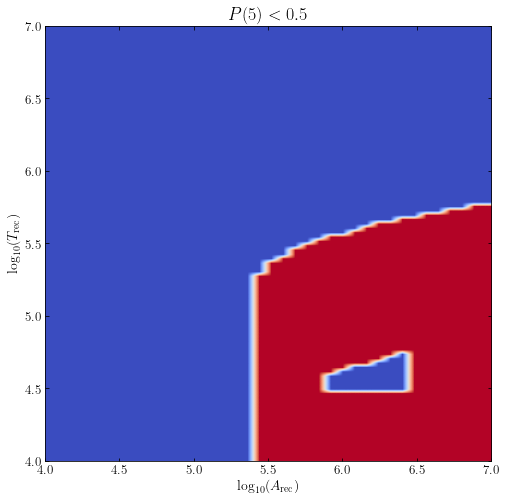

In [382]:
plt.figure(figsize=(8, 8))
plt.imshow(limit_grid, cmap='coolwarm', extent=[-1, 7, 4, 7], aspect='auto', interpolation='bilinear')
plt.xlim(4,7)
plt.ylim(4,7)
plt.xlabel('$\log_{10}(A_\mathrm{rec})$')
plt.ylabel('$\log_{10}(T_\mathrm{rec})$')
plt.title('$P({}) < {}$'.format(k_crit, crit_val))
# plt.savefig('Figures/recoupling_constraint.pdf')
plt.show()

In [383]:
path = "observation_data/"

####DES####
dfDES = pd.read_csv(path + "DESY1.csv")
dfDES = dfDES.assign(
    ylow=dfDES["Y"] - dfDES["-DeltaY"], yhigh=dfDES["+DeltaY"] - dfDES["Y"]
)
dfDES = dfDES.assign(
    xlow=dfDES["X"] - dfDES["-DeltaX"], xhigh=dfDES["+DeltaX"] - dfDES["X"]
)
yerrDES = np.array([dfDES["ylow"], dfDES["yhigh"]])
xerrDES = np.array([dfDES["xlow"], dfDES["xhigh"]])

####BOSS####
columns = ["k", "P(k)", "delta P(k)+", "delta P(k)-"]
dfBOSS = pd.read_csv(path + "BOSS.csv", header=None)
dfBOSS.columns = columns

dfBOSS = dfBOSS.assign(
    ylow=dfBOSS["P(k)"] - dfBOSS["delta P(k)-"],
    yhigh=dfBOSS["delta P(k)+"] - dfBOSS["P(k)"],
)
yerrBOSS = np.array([dfBOSS["ylow"], dfBOSS["yhigh"]])


####PLANCK####
dfPlanckTT = pd.read_csv(path + "PlanckTT.csv", skiprows=1)
dfPlanckEE = pd.read_csv(path + "PlanckEE.csv", skiprows=1)
dfPlanckPP = pd.read_csv(path + "PlanckPP.csv", skiprows=1)

dfPlanckTT = dfPlanckTT.assign(
    ylow=dfPlanckTT["Y"] - dfPlanckTT["Y.3"], yhigh=dfPlanckTT["Y.4"] - dfPlanckTT["Y"]
)
dfPlanckTT = dfPlanckTT.assign(
    xlow=dfPlanckTT["X"] - dfPlanckTT["X.1"], xhigh=dfPlanckTT["X.2"] - dfPlanckTT["X"]
)
yerrTT = np.array([dfPlanckTT["ylow"], dfPlanckTT["yhigh"]])
xerrTT = np.array([dfPlanckTT["xlow"], dfPlanckTT["xhigh"]])

dfPlanckEE = dfPlanckEE.assign(
    ylow=dfPlanckEE["Y"] - dfPlanckEE["Y.3"], yhigh=dfPlanckEE["Y.4"] - dfPlanckEE["Y"]
)
dfPlanckEE = dfPlanckEE.assign(
    xlow=dfPlanckEE["X"] - dfPlanckEE["X.1"], xhigh=dfPlanckEE["X.2"] - dfPlanckEE["X"]
)
yerrEE = np.array([dfPlanckEE["ylow"], dfPlanckEE["yhigh"]])
xerrEE = np.array([dfPlanckEE["xlow"], dfPlanckEE["xhigh"]])

dfPlanckPP = dfPlanckPP.assign(
    ylow=dfPlanckPP["Y"] - dfPlanckPP["Y.3"], yhigh=dfPlanckPP["Y.4"] - dfPlanckPP["Y"]
)
dfPlanckPP = dfPlanckPP.assign(
    xlow=dfPlanckPP["X"] - dfPlanckPP["X.1"], xhigh=dfPlanckPP["X.2"] - dfPlanckPP["X"]
)
yerrPP = np.array([dfPlanckPP["ylow"], dfPlanckPP["yhigh"]])
xerrPP = np.array([dfPlanckPP["xlow"], dfPlanckPP["xhigh"]])


In [656]:
#sort all relevant data by ks
# constraint_ks = np.concatenate((dfBOSS["k"], dfDES["X"], dfPlanckTT["X"], dfPlanckEE["X"], dfPlanckPP["X"]))
# constraint_pks = np.concatenate((dfBOSS["P(k)"], dfDES["Y"], dfPlanckTT["Y"], dfPlanckEE["Y"], dfPlanckPP["Y"]))
# constraint_pk_y_errs = np.concatenate((yerrBOSS, yerrDES, yerrTT, yerrEE, yerrPP), axis=1)

# constraint_ks = np.concatenate((dfDES["X"], dfPlanckTT["X"], dfPlanckEE["X"], dfPlanckPP["X"]))
# constraint_pks = np.concatenate((dfDES["Y"], dfPlanckTT["Y"], dfPlanckEE["Y"], dfPlanckPP["Y"]))
# constraint_pk_y_errs = np.concatenate((yerrDES, yerrTT, yerrEE, yerrPP), axis=1)

constraint_ks = np.concatenate((dfDES["X"], dfPlanckPP["X"]))
constraint_pks = np.concatenate((dfDES["Y"], dfPlanckPP["Y"]))
constraint_pk_y_errs = np.concatenate((yerrDES, yerrPP), axis=1)
constraint_pk_x_errs = np.concatenate((xerrDES, xerrPP), axis=1)



constraint_ks_sorted = sorted(constraint_ks)
constraint_pks_sorted = [x for _, x in sorted(zip(constraint_ks, constraint_pks))]
constraint_pk_y_errs_sorted = np.zeros((2, len(constraint_ks)))
constraint_pk_y_errs_sorted[0] = np.array([x for _, x in sorted(zip(constraint_ks, constraint_pk_y_errs[0]))])
constraint_pk_y_errs_sorted[1] = np.array([x for _, x in sorted(zip(constraint_ks, constraint_pk_y_errs[1]))])
constraint_pk_y_var_sorted = np.zeros((2, len(constraint_ks)))
constraint_pk_y_var_sorted[0] = constraint_pk_y_errs_sorted[0]
constraint_pk_y_var_sorted[1] = constraint_pk_y_errs_sorted[1]


constraint_pk_x_errs_sorted = np.zeros((2, len(constraint_ks)))
constraint_pk_x_errs_sorted[0] = [x for _, x in sorted(zip(constraint_ks, constraint_pk_x_errs[0]))]
constraint_pk_x_errs_sorted[1] = [x for _, x in sorted(zip(constraint_ks, constraint_pk_x_errs[1]))]
constraint_pk_x_var_sorted = np.zeros((2, len(constraint_ks)))
constraint_pk_x_var_sorted[0] = constraint_pk_x_errs_sorted[0]
constraint_pk_x_var_sorted[1] = constraint_pk_x_errs_sorted[1]


In [682]:
Tr1 = T_rec_strong_arr[80]
Ar1 = A_rec_strong_arr[99]
test_pks = np.zeros(len(constraint_ks_sorted))
for i, k in enumerate(constraint_ks_sorted):
    # test_pks[i] = pk_strong_interp((Tr1, Ar1, k))
    test_pks[i] = pk_strong_interp_late((Tr1, Ar1, k))


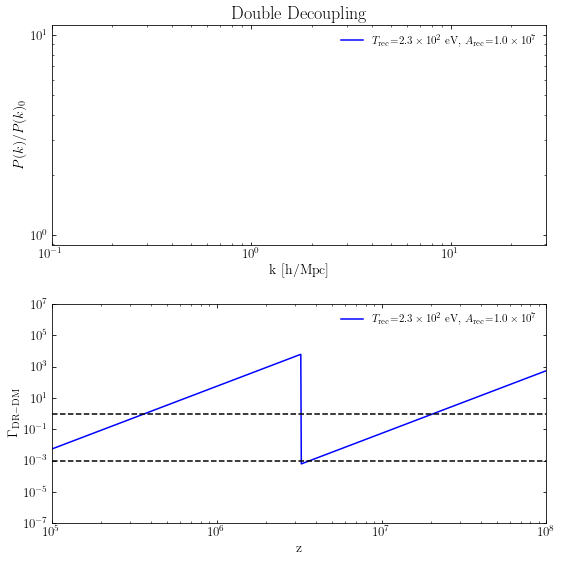

In [683]:
plot_varied_recoupling_strong(Tr0, Ar0, Tr1, Ar1, save=False)


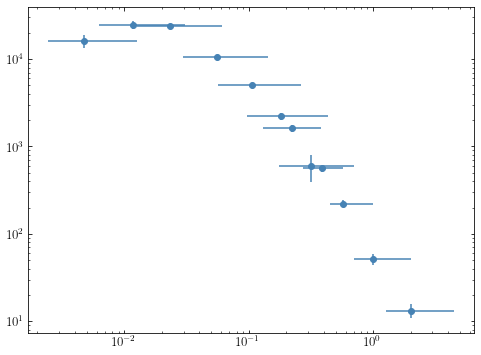

In [684]:
# plt.loglog(constraint_ks_sorted, constraint_pks_sorted, 'o')
plt.errorbar(constraint_ks_sorted, constraint_pks_sorted, yerr=constraint_pk_y_var_sorted, xerr=constraint_pk_x_var_sorted,fmt='o', label='Observations')
plt.loglog(constraint_ks_sorted, test_pks)
plt.show()

In [685]:
logy = np.log10(constraint_pks_sorted)
logytest = np.log10(test_pks)
logx = np.log10(constraint_ks_sorted)
logxerr = np.log10(constraint_pk_x_var_sorted)
logyerr = np.log10(constraint_pk_y_var_sorted)
chi2_stat = np.sum((logy - logytest)**2 / logyerr**2 + ((logx - np.mean(logx)) / np.mean(logxerr))**2)
p_value = 1.0 - chi2.cdf(chi2_stat, len(constraint_ks_sorted))

print("Chi2:  ", chi2_stat)
print("P-value: ", p_value)
if p_value < 0.05:
    print("Model does not fit data")
else:
    print("Model fits data")

Chi2:   inf
P-value:  0.0
Model does not fit data


In [447]:
def make_constraint_chisquare():
    chi2_grid = np.zeros((N_points, N_points))

    for i, Tr in enumerate(T_rec_arr):
        for j, Ar in enumerate(A_rec_strong_arr):
            # test_pks = np.array([pk_strong_interp((Tr, Ar, k)) for k in constraint_ks_sorted])
            test_pks = np.array([pk_strong_interp_late((Tr, Ar, k)) for k in constraint_ks_sorted])

            chi2 = np.sum((constraint_pks_sorted - test_pks)**2 / constraint_pk_y_var_sorted**2)
            chi2_grid[i, j] = chi2
    return chi2_grid

def make_constraint_grid_chisquare(chi2_grid):
    #crit_val = 36.42 #for 24 points
    crit_val = chi2.isf(0.1, len(constraint_ks_sorted))
    limit_grid = np.zeros((N_points, N_points))
    for i in range(N_points):
        for j in range(N_points):
            if chi2_grid[i, j] > crit_val:
                limit_grid[i, j] = 1
    return limit_grid


In [448]:
chi2_grid = make_constraint_chisquare()

KeyboardInterrupt: 

In [ ]:
limit_grid_chi2 = make_constraint_grid_chisquare(chi2_grid)

In [406]:
limit_grid_chi2

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [403]:
limit_grid_chi2

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

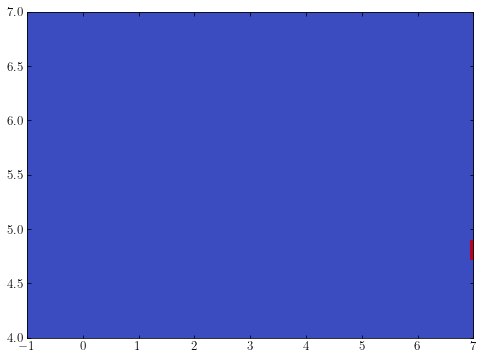

In [371]:
plt.imshow(limit_grid_chi2, cmap='coolwarm', extent=[-1, 7, 4, 7], aspect='auto', interpolation='nearest')

# plt.ylim(5.5,7)
plt.show()

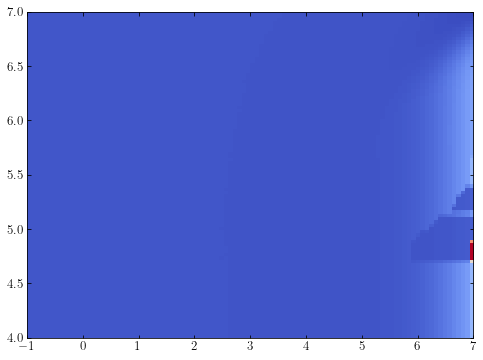

In [351]:
plt.imshow(chi2_grid, cmap='coolwarm', extent=[-1, 7, 4, 7], aspect='auto', interpolation='nearest', norm=LogNorm(vmin=np.min(chi2_grid), vmax=np.max(chi2_grid)))

plt.show()

Try Lambda CDM and see if it agrees with the constraints or if it's a recoupling issue.

In [407]:
dfLCDM = pd.read_csv(
            'output/lambdacdm00_pk.dat', header=None, names=["k", "P(k)"], skiprows=4, delimiter="\s+",
        )

In [653]:
lcdm_interp = UnivariateSpline(dfLCDM["k"], dfLCDM["P(k)"], s=0)
lcdm_pks = np.array([lcdm_interp(k) for k in constraint_ks_sorted])


In [654]:
print(np.sum((constraint_pks_sorted - test_pks)**2 / constraint_pk_y_var_sorted**2))
print(np.sum((constraint_pks_sorted - lcdm_pks)**2 / constraint_pk_y_var_sorted**2))

59.658802261092916
72.81990808559624


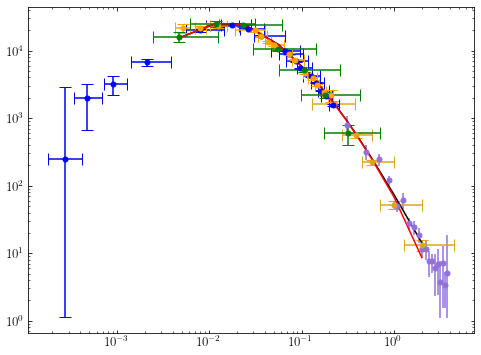

In [655]:
plt.errorbar(
    dfBOSS["k"],
    dfBOSS["P(k)"],
    yerr=yerrBOSS,
    marker="o",
    ms=5,
    color="mediumpurple",
    ls="none",
    label=r"BOSS DR9 Ly-$\alpha$ forest",
)
plt.errorbar(
    dfDES["X"],
    dfDES["Y"],
    yerr=yerrDES,
    xerr=xerrDES,
    marker="o",
    ms=5,
    color="goldenrod",
    ls="none",
    capsize=6,
    label="DES Y1 cosmic Shear",
)

plt.errorbar(
    dfPlanckTT["X"],
    dfPlanckTT["Y"],
    yerr=yerrTT,
    xerr=xerrTT,
    marker="o",
    ms=5,
    color="blue",
    ls="none",
    capsize=6,
    label="Planck TT",
)

plt.errorbar(
    dfPlanckEE["X"],
    dfPlanckEE["Y"],
    yerr=yerrEE,
    xerr=xerrEE,
    marker="o",
    ms=5,
    color="orange",
    ls="none",
    capsize=6,
    label="Planck EE",
)

plt.errorbar(
    dfPlanckPP["X"],
    dfPlanckPP["Y"],
    yerr=yerrPP,
    xerr=xerrPP,
    marker="o",
    ms=5,
    color="green",
    ls="none",
    capsize=6,
    label="Planck $\phi\phi$",
)

# plt.plot(constraint_ks_sorted, constraint_pks_sorted, color="black", label="Constraint")
# plt.errorbar(constraint_ks_sorted, constraint_pks_sorted, yerr=constraint_pk_y_errs_sorted, color="black", ls="none", alpha=0.5)
plt.plot(constraint_ks_sorted, lcdm_pks, color="black", label="LCDM")
plt.plot(constraint_ks_sorted, test_pks, color="red", label="Recoupling")

plt.xscale("log")
plt.yscale("log")

# plt.xlim(1e-2, 1e-1)
# plt.ylim(1e3, 5e4)

plt.show()